# 1 - Preparing data

In [230]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [5]:
mypath = "./data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['Books_small.json',
 'Grocery_small.json',
 'Clothing_small.json',
 'Patio_small.json',
 'Electronics_small.json']

In [6]:
data = pd.DataFrame()
for file in onlyfiles:
    path = mypath +'/'+ file
    df = pd.read_json(path,lines=True)
    df['category'] = file.split("_")[0] 
    data = pd.concat([data,df],axis=0,sort=True)
    
data.to_csv('./complete_data.csv',index=False)

In [5]:
#data = pd.read_csv('complete_data.csv')
data.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1495329321,Books,"[0, 0]",4,Da Silva takes the divine by storm with this u...,"03 30, 2014",A1E5ZR1Z4OQJG,"Pure Jonel ""Pure Jonel""",An amazing first novel,1396137600
1,0399157565,Books,"[0, 0]",2,For me personally it's the most disappointing ...,"05 15, 2014",A30PZPI6FPH0A7,Jackmollie,disappointed,1400112000
2,0984528105,Books,"[0, 0]",4,"Very simple book, but leaves you feeling good....","05 28, 2014",A1GQ2UI5BKCCRD,Gail Hodges,Good book,1401235200
3,0804139024,Books,"[0, 0]",5,I read a library copy of this exceptionally we...,"04 3, 2014",A2DF4LQQI6KSQ2,Olga,Science Fiction at its best!,1396483200
4,0765317583,Books,"[0, 0]",5,With the government knowing this could happen ...,"04 9, 2014",A1UAMAWY966P2,Nadyne M Ichimura,Excellent story,1397001600


In [6]:
data['category'].value_counts()

Electronics    1000
Books          1000
Grocery        1000
Patio          1000
Clothing       1000
Name: category, dtype: int64

In [7]:
data.shape

(5000, 10)

# 2 - Train_test split

In [8]:
X = data['reviewText']
y = data['category']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=0)

# 3 -  TF-IDF: Term’s Frequency (TF) Inverse Document Frequency (IDF).

## TF: The frequency of a word in a document(text). When you know it, you’re able to see if you’re using a term too much or too little. 

$TF(t) = \dfrac{Number \ of \ times \ word \ t \ appears \ in \ a \ document}{Total \ number \ of \ words \ in \ the \ document}$

## IDF: The measure of how significant that term is in the whole corpus.

$IDF(t) = log_e \bigg(\dfrac{Total \ number \ of \ documents}{Number \ of \ documents \ with \ word \ t \ in \ it}\bigg) $

# TF-IDF = TF*IDF
##  The higher the TF*IDF value, the rarer the term. The smaller the weight, the more common the term.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [271]:
vectorizer = TfidfVectorizer()
X_train_vectorized=vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

# 4 - Latent Semantic Analysis 

In [36]:
from sklearn.decomposition import TruncatedSVD
import time

In [268]:
t0 = time.time()

svd = TruncatedSVD(n_components=X_train_vectorized.shape[0])
X_train_svd = svd.fit_transform(X_train_vectorized)

X_test_svd = svd.transform(X_test_vectorized)

print('total time taken:',time.time()-t0)

total time taken: 95.63107585906982


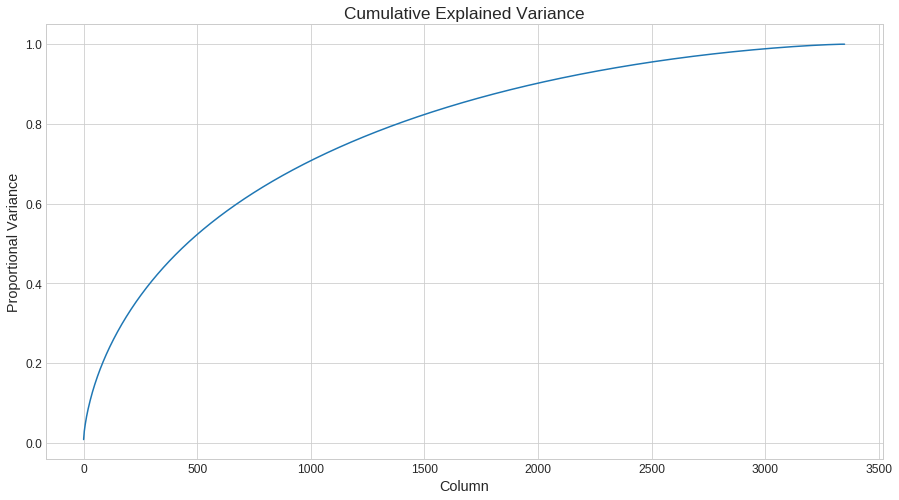

In [269]:
plt.figure(figsize=(15,8))
plt.title('Cumulative Explained Variance',size='xx-large')
plt.xlabel('Column',size='x-large')
plt.xticks(size='large')
plt.ylabel('Proportional Variance',size='x-large')
plt.yticks(size='large')
plt.plot(range(svd.explained_variance_ratio_.shape[0]),svd.explained_variance_ratio_.cumsum())
plt.show()



### It takes approximately 2000 columns to go from 0.8 to 1.0 and only 500 to go from 0.6 to 0.8

In [87]:
#from sklearn.utils.extmath import safe_sparse_dot

# Getting the projection on the first 1500 columns
#X_train_svd = safe_sparse_dot(X_train_vectorized,svd.components_[:1500].T)
#X_test_svd = safe_sparse_dot(X_test_vectorized,svd.components_[:1500].T)

#X_train_svd.shape

In [272]:
X_train_vectorized=pd.DataFrame(data=X_train_vectorized.toarray(),columns = vectorizer.get_feature_names())
X_test_vectorized=pd.DataFrame(data=X_test_vectorized.toarray(),columns = vectorizer.get_feature_names())

In [273]:
n_pcs = svd.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(svd.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_train_vectorized.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}


# each feature impacts each PC(eigenvector) diferently
df_svd = pd.DataFrame(dic.items(),columns=['PCs','Most Important Feature'])
df_svd=df_svd.set_index('PCs')
df_svd

,Most Important Feature
PCs,
PC0,the
PC1,they
PC2,it
PC3,the
PC4,you
...,...
PC3345,ounce
PC3346,03pm
PC3347,103


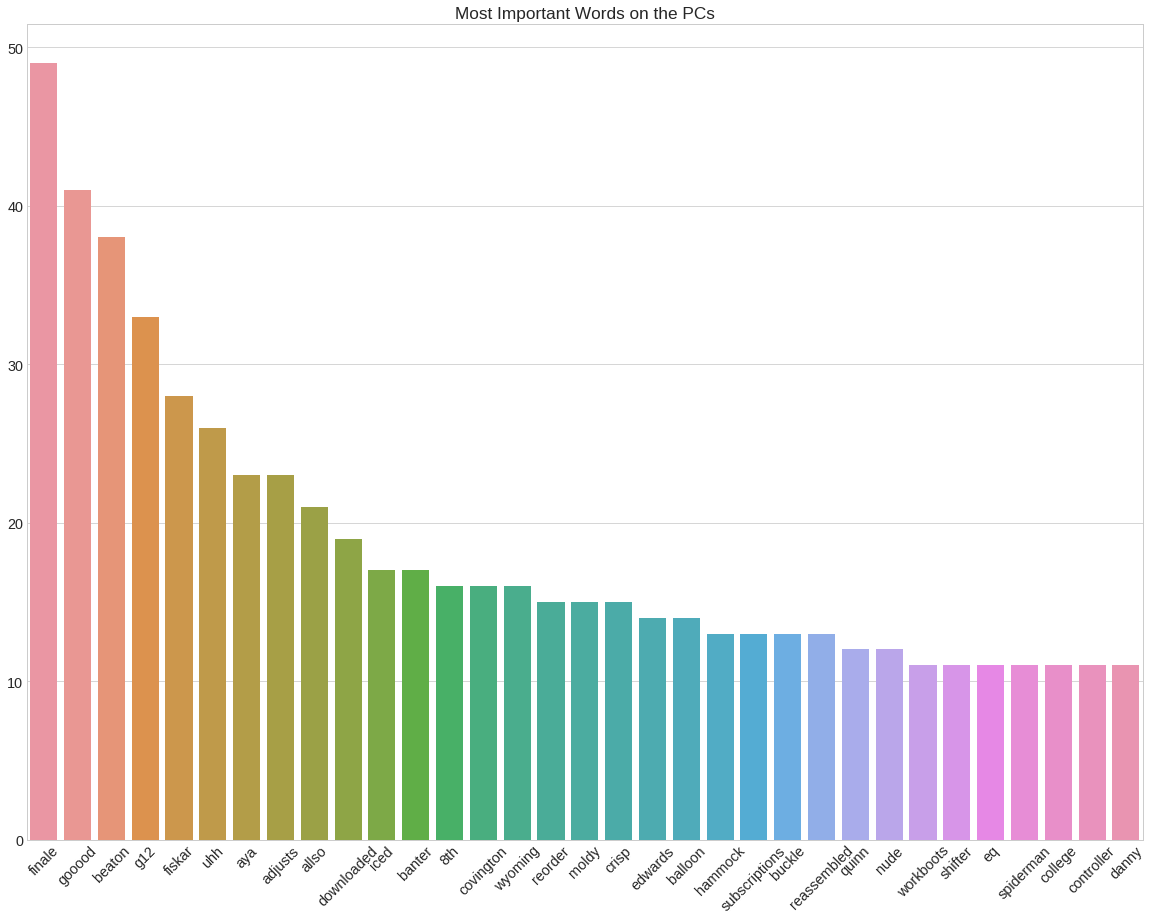

In [274]:
threshold = 10
sorted_most_important = df_svd['Most Important Feature'].value_counts()
sorted_most_important = sorted_most_important[sorted_most_important>threshold]


plt.figure(figsize=(20,15))
plt.title('Most Important Words on the PCs',size='xx-large')
plt.yticks(size='x-large')
fig=sns.barplot(x=sorted_most_important.keys(),y=sorted_most_important.values)
fig.set_xticklabels(fig.get_xticklabels(),rotation=45,size='x-large')
plt.show()


# 5 - Classificators

In [260]:
from sklearn.metrics import classification_report,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC

In [277]:
dict_classifiers = {"Logistic Regression": LogisticRegression(solver = "liblinear",random_state=42),
    "LinearSVC": LinearSVC(random_state=0),
    "SVC":SVC(random_state=0)
}

In [278]:
classifiers_names = list(dict_classifiers.keys())
classifiers_values=list(dict_classifiers.values())


In [281]:
def train_model(model,svd=False):
    if svd:
        model.fit(X_train_svd,y_train)
        y_test_pred = model.predict(X_test_svd)
    else:
        model.fit(X_train_vectorized,y_train)
        y_test_pred = model.predict(X_test_vectorized)
    
    print('f1 = ',f1_score(y_test, y_test_pred,average='weighted'))
    print('\n')
    return times

In [280]:
def train_model_svd(model):
    model.fit(X_train_svd,y_train)
    y_test_pred = model.predict(X_test_svd)
    print('f1 = ',f1_score(y_test, y_test_pred,average='weighted'))
    print('\n')
    return times

In [282]:
times,precs = [],[]
names = ['No_SVD','Yes_SVD']
flag = False
for name in names:
    print('--'*15+f'{name}'+'--'*15)
    for key,value in zip(classifiers_names,classifiers_values):
        print('--'*6+f'{key}'+'--'*6)
        Time=train_model(value,flag)
        times.append(Time)
    flag = True

------------------------------No_SVD------------------------------
------------Logistic Regression------------
chegou False 

f1 =  0.9176915264776075


------------LinearSVC------------
chegou False 

f1 =  0.9327573089127635


------------SVC------------
chegou False 

f1 =  0.9150758523436503


------------------------------Yes_SVD------------------------------
------------Logistic Regression------------
chegou True 

f1 =  0.9176915264776075


------------LinearSVC------------
chegou True 

f1 =  0.9327573089127635


------------SVC------------
chegou True 

f1 =  0.9071239432061207




In [276]:
print(X_train_vectorized.shape)
print(X_train_svd.shape)

(3350, 16546)
(3350, 3350)


## SVD drastically reduces the number of columns and preserves the matrix's variance

# 6 - Grid_search

In [95]:
from sklearn.model_selection import GridSearchCV

In [292]:
model = LinearSVC(random_state=0)
penalty = ['l1', 'l2']
multi_class = ['ovr','crammer_singer']
C = [1, 10, 100, 1000]
loss = ['hinge', 'squared_hinge']

parameters = dict(penalty=penalty, multi_class=multi_class, C=C,loss=loss)

grid = GridSearchCV(model, parameters, cv = 3, verbose = 2, n_jobs = 3,scoring='f1_weighted')
grid.fit(X_train_svd, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  41 tasks      | elapsed:   55.3s
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed:  9.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=0, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=3,
             param_grid={'C': [1, 10, 100, 1000],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [293]:
grid.best_score_

0.9253968667299538

In [295]:
print(grid.best_estimator_)
model = grid.best_estimator_

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=0, tol=0.0001, verbose=0)


# 7 - Evaluation

In [296]:
scores = cross_val_score(model, pd.concat([X_train_vectorized,X_test_vectorized]), pd.concat([y_train,y_test]), cv = 5, scoring='f1_weighted')
scores

array([0.93124727, 0.95089009, 0.93613789, 0.93973459, 0.9329417 ])

In [297]:
y_test_pred = model.predict(X_test_svd)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       Books       0.98      0.97      0.98       312
    Clothing       0.91      0.93      0.92       334
 Electronics       0.92      0.89      0.91       346
     Grocery       0.94      0.94      0.94       328
       Patio       0.93      0.94      0.93       330

    accuracy                           0.94      1650
   macro avg       0.94      0.94      0.94      1650
weighted avg       0.94      0.94      0.94      1650



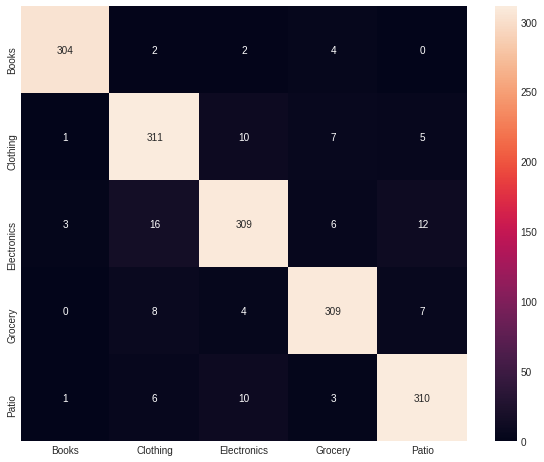

In [298]:
labels = ['Books','Clothing','Electronics','Grocery','Patio']
conf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels)
conf_matrix = pd.DataFrame(conf_matrix,index=labels,columns=labels) 

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt='d')